# Unlocking Church Growth: Data Insights from the National Congregations Study
# Facilities Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Facilities of the congregation and how they may impact an attendance change. The features included are:<br>
 - Building: The type of building used for the primary worship services (i.e., School, Storefront, Church/Synagogue/Temple/Mosque, or Other)
 - Artwork: identifies if visitors come to view the architecure, artwork, stained glass, or statues
 - Remodel: was there a remodel in recent years?
 - Founded: year the primary building was founded
 - Home School: are homeschool group(s) sponsored?
 - School: K-12 school onsite
 - Building Use: Other groups, programs or events not connected to the congeregation
 - Permits: permits or licenses are obtained (i.e., Kitchen, Remodeling, Liquor, Day Care, Bingo/Gambling/Raffle, Statue/Signage, Festival/Bazaar, Zoning, Tax Exemption, etc.)

## Data Preparation

In [77]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import itertools
import matplotlib.colors as mcolors  # Import the mcolors module


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [52]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [53]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [54]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [55]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [57]:
# Renaming the columns
data.rename(columns={
    'BLDGTYPE': 'Building Type',
    'VIEWBLDG': 'Artwork/Architecture',
    'REMODEL': 'Remodel',
    'HOMESCHL': 'Home School',
    'HAVESCHL': 'Primary & Secondary Education',
    'USEBLDG': 'Building Use',
    'PERMPURP': 'Permit & Purpose'
}, inplace=True)

In [58]:
# Select specific features
selected_columns = ['DENOM', 'Building Type', 'Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use', 'Permit & Purpose', 'change_category']
df_facilities = data[selected_columns].copy()

In [60]:
# Change column data types for FACILITIES
df_facilities['Building Type'] = df_facilities['Building Type'].astype('category')
df_facilities['Permit & Purpose'] = df_facilities['Permit & Purpose'].astype('category')

In [61]:
# Drop DENOM
df_facilities.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_facilities.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_facilities[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
#df_facilities_encoded = pd.concat([df_facilities.reset_index(drop=True), encoded_df], axis=1)
df_facilities_encoded = pd.concat([df_facilities, encoded_df], axis=1)
df_facilities_encoded = df_facilities_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [62]:
# Basic exploration
df_facilities.info()
df_facilities.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Building Type                  5327 non-null   category
 1   Artwork/Architecture           1228 non-null   object  
 2   Remodel                        1420 non-null   object  
 3   Home School                    1505 non-null   object  
 4   Primary & Secondary Education  5318 non-null   object  
 5   Building Use                   2293 non-null   object  
 6   Permit & Purpose               413 non-null    category
 7   change_category                5333 non-null   category
dtypes: category(3), object(5)
memory usage: 225.7+ KB


,Building Type,Artwork/Architecture,Remodel,Home School,Primary & Secondary Education,Building Use,Permit & Purpose,change_category
count,5327,1228,1420,1505,5318,2293,413,5333
unique,4,2,2,2,2,2,29,3
top,"Church, Synagogue, Temple, or Mosque",True,False,False,False,True,Buliding/Remodeling,Same
freq,5076,652,955,1295,4304,1573,176,4383


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

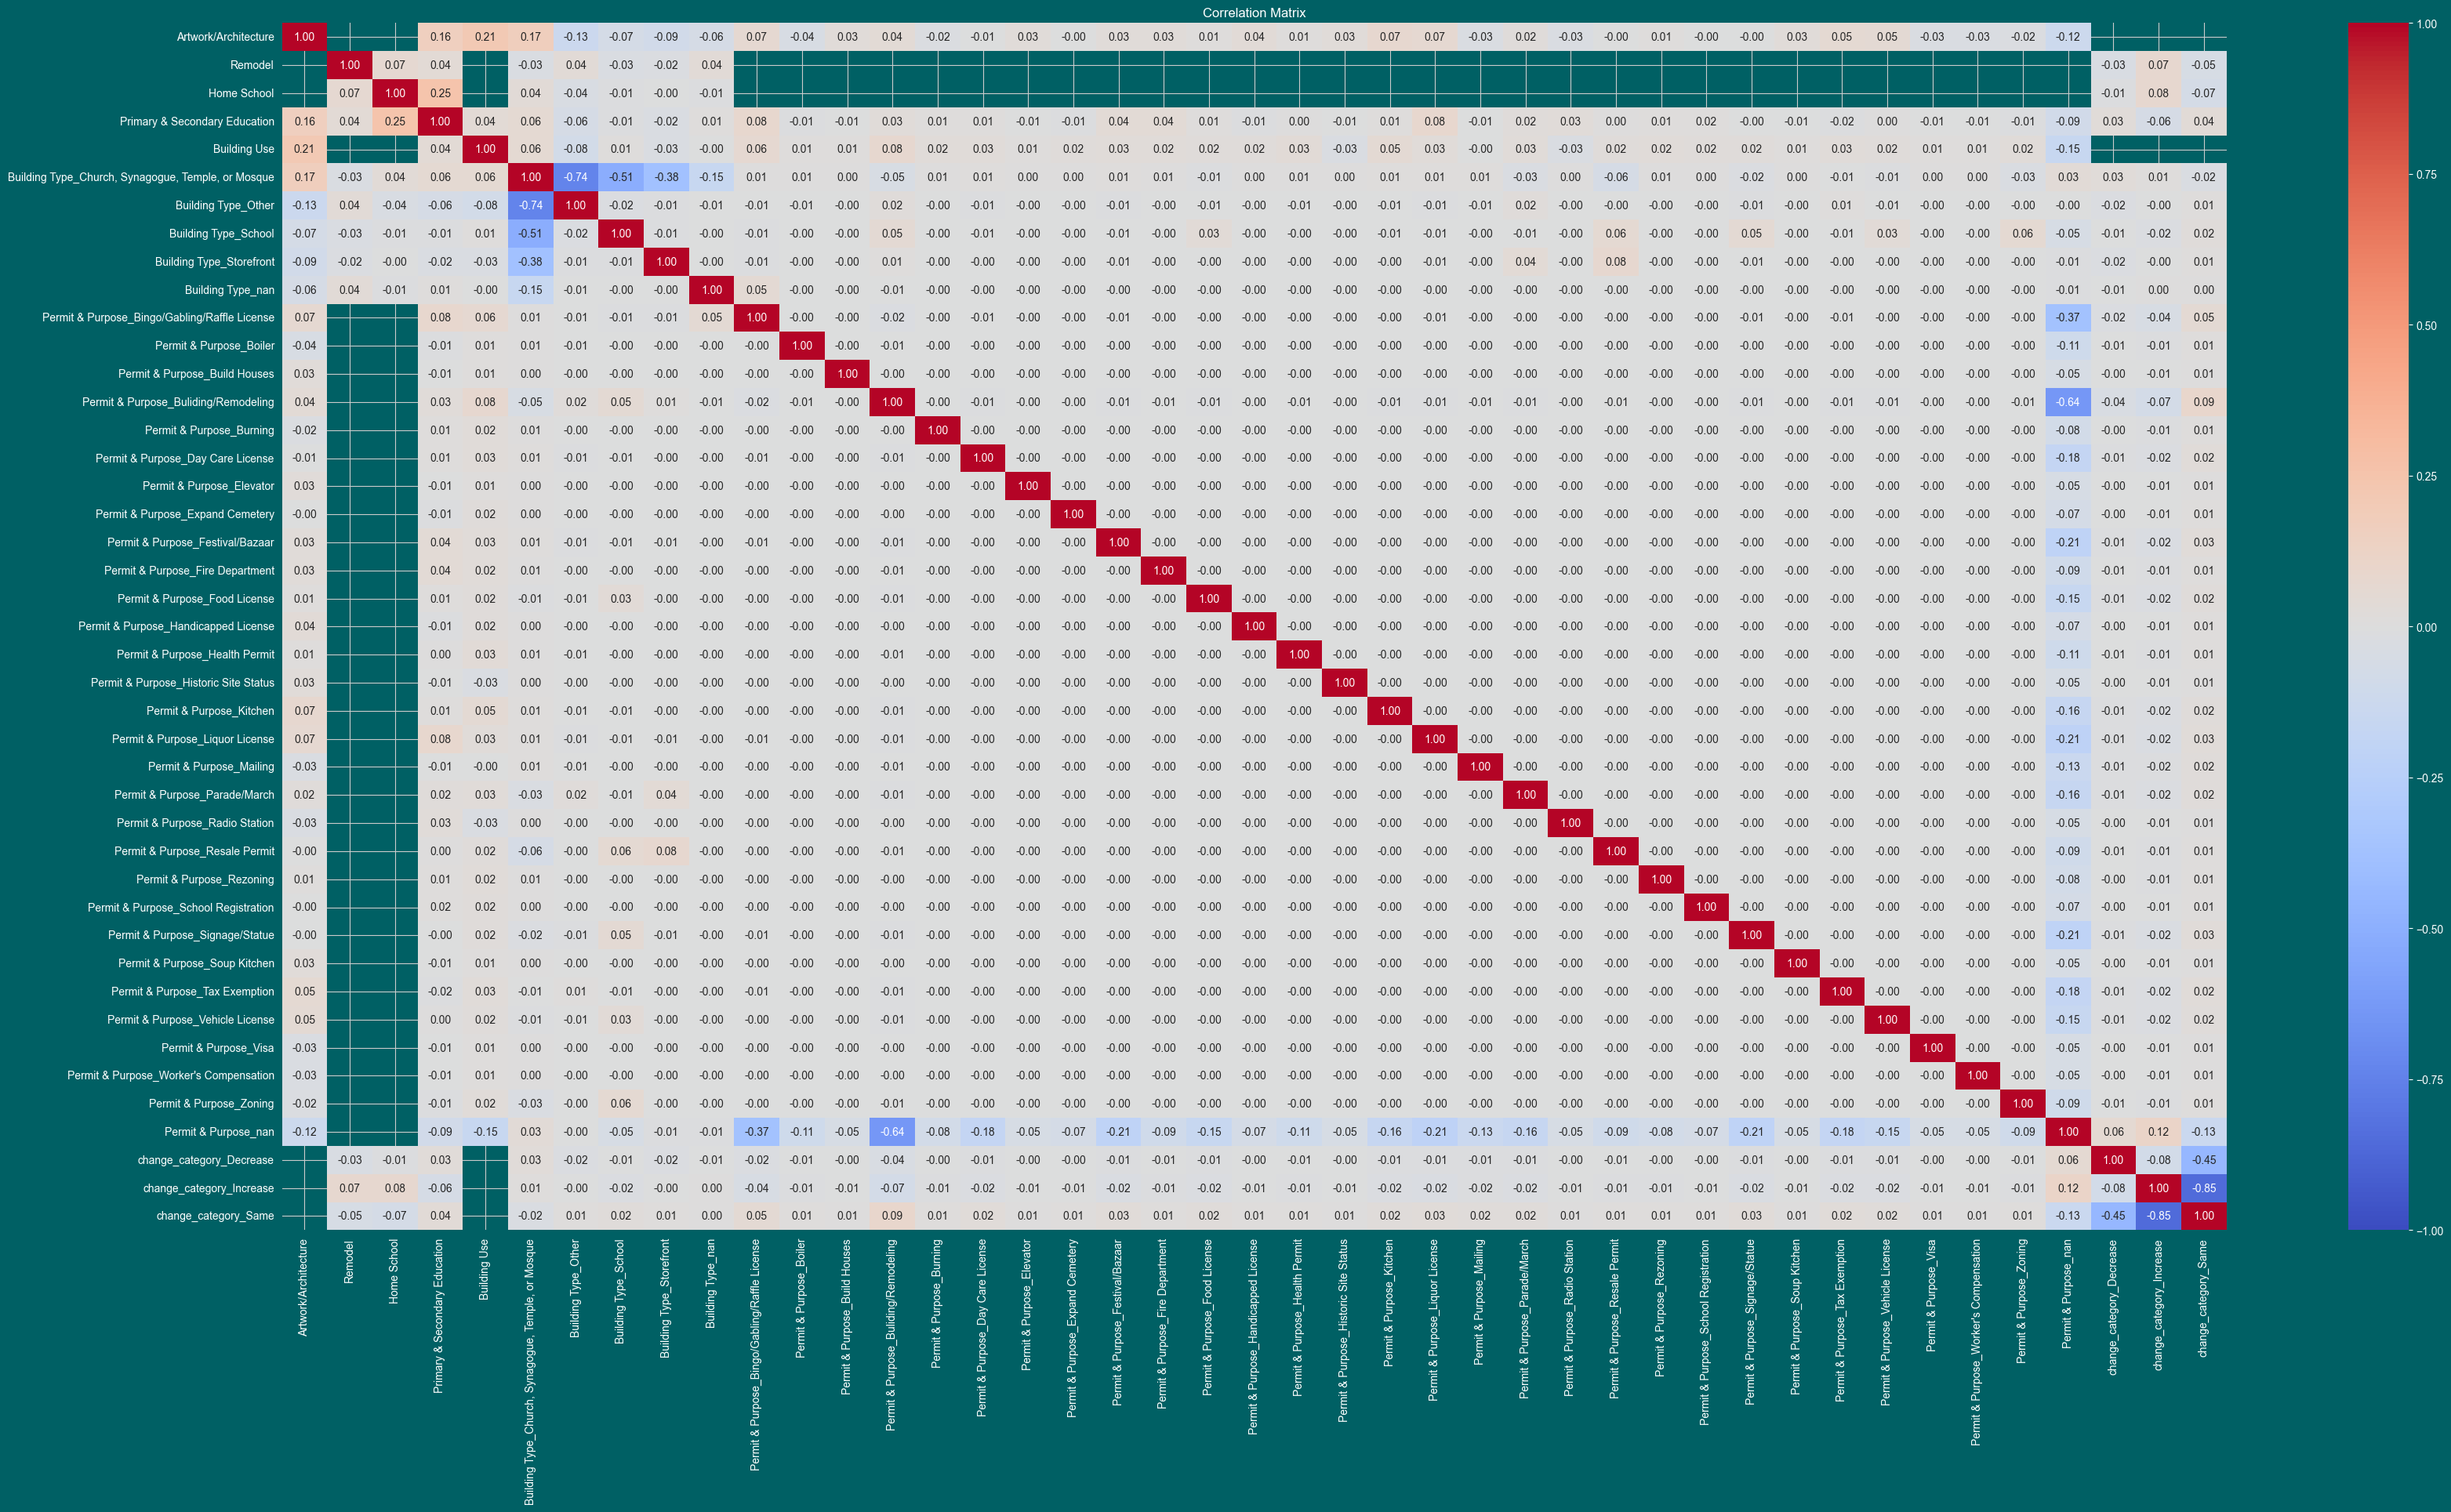

In [63]:
# Perform correlation analysis
correlation_matrix = df_facilities_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

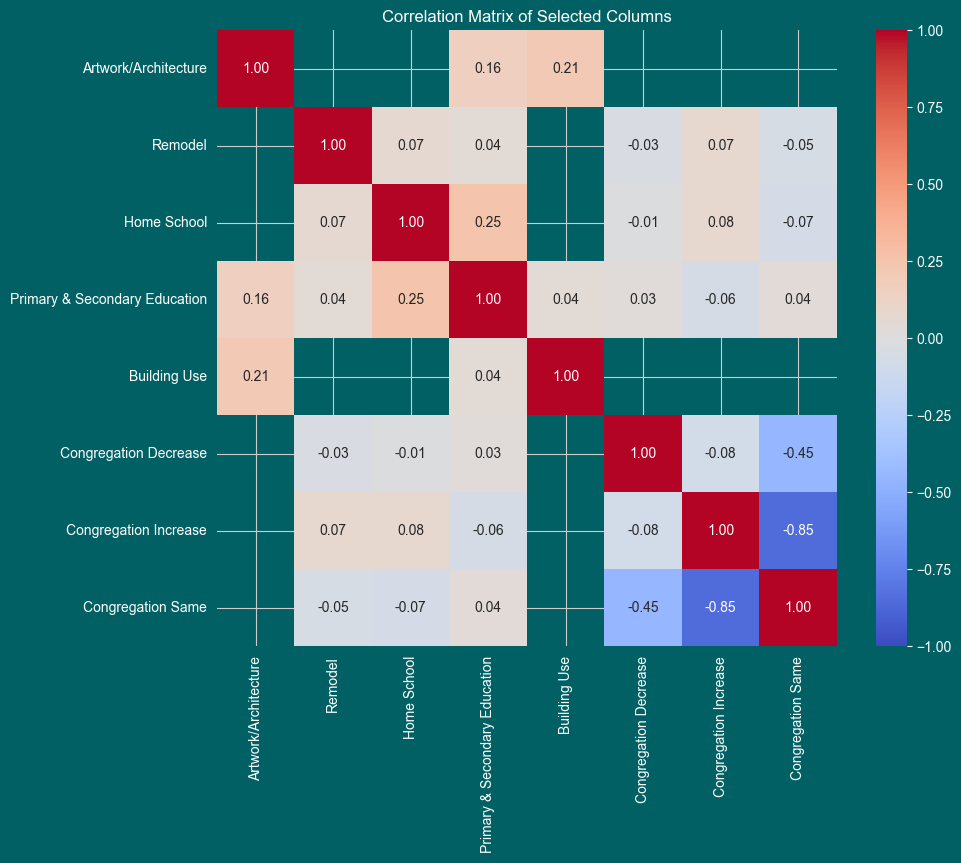

In [75]:
# Subset the DataFrame to include only the specified columns
subset_columns = ['Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use', 'change_category_Decrease', 'change_category_Increase', 'change_category_Same']
subset_df = df_facilities_encoded[subset_columns]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Rename the columns and index in the correlation matrix
correlation_matrix.rename(columns={
    'change_category_Increase': 'Congregation Increase',
    'change_category_Decrease': 'Congregation Decrease',
    'change_category_Same': 'Congregation Same'
}, inplace=True)

correlation_matrix.rename(index={
    'change_category_Increase': 'Congregation Increase',
    'change_category_Decrease': 'Congregation Decrease',
    'change_category_Same': 'Congregation Same'
}, inplace=True)

# Set the size of the plot
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix of Selected Columns')
plt.show()

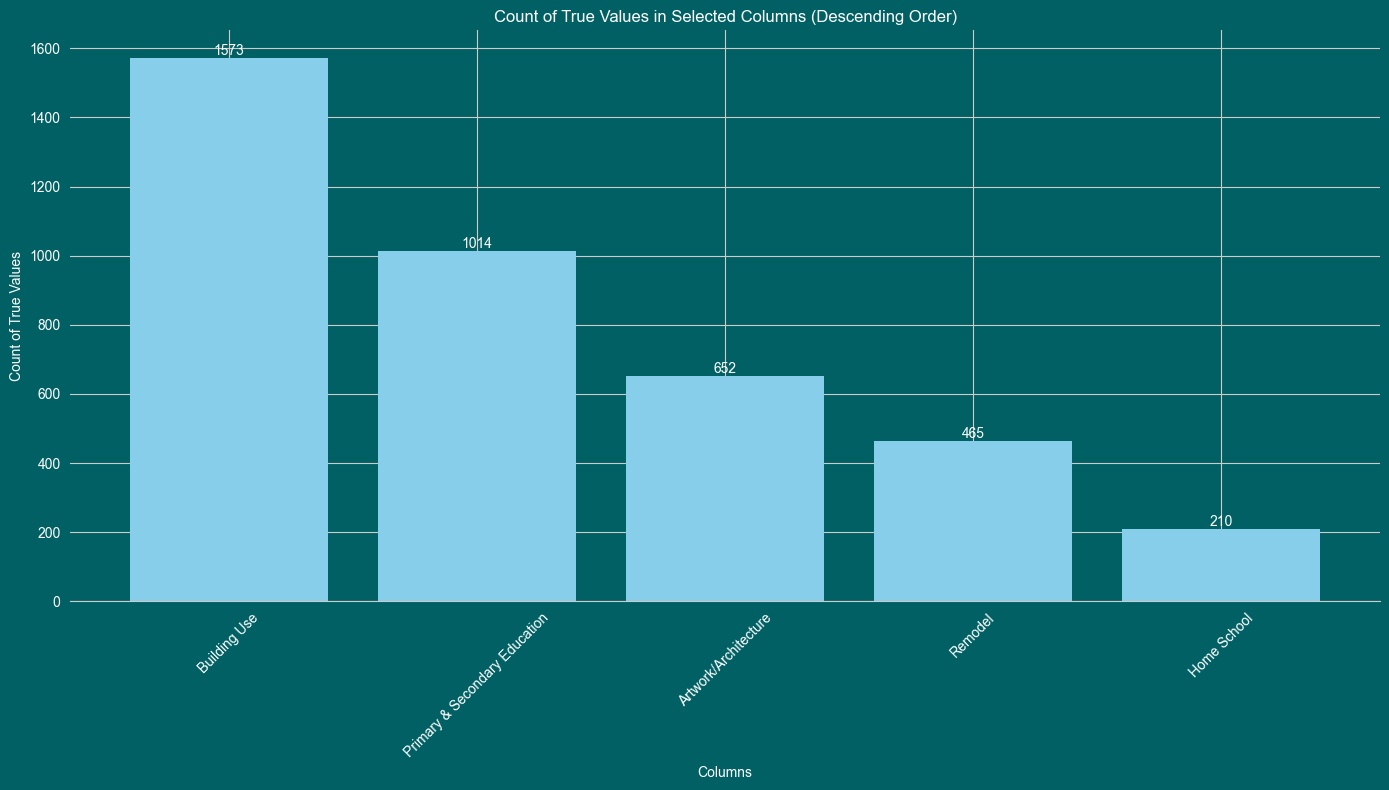

In [94]:
# Specify columns of interest
columns_of_interest = ['Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use']

# Count True values for each column
counts = {col: df_facilities_encoded[col].sum() for col in columns_of_interest}

# Sort counts in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Plot counts for each column as multiple bars in one graph
plt.figure(figsize=(14, 8))

# Create the bar plot with sorted counts
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count of True Values')
plt.title('Count of True Values in Selected Columns (Descending Order)')

# Adding data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

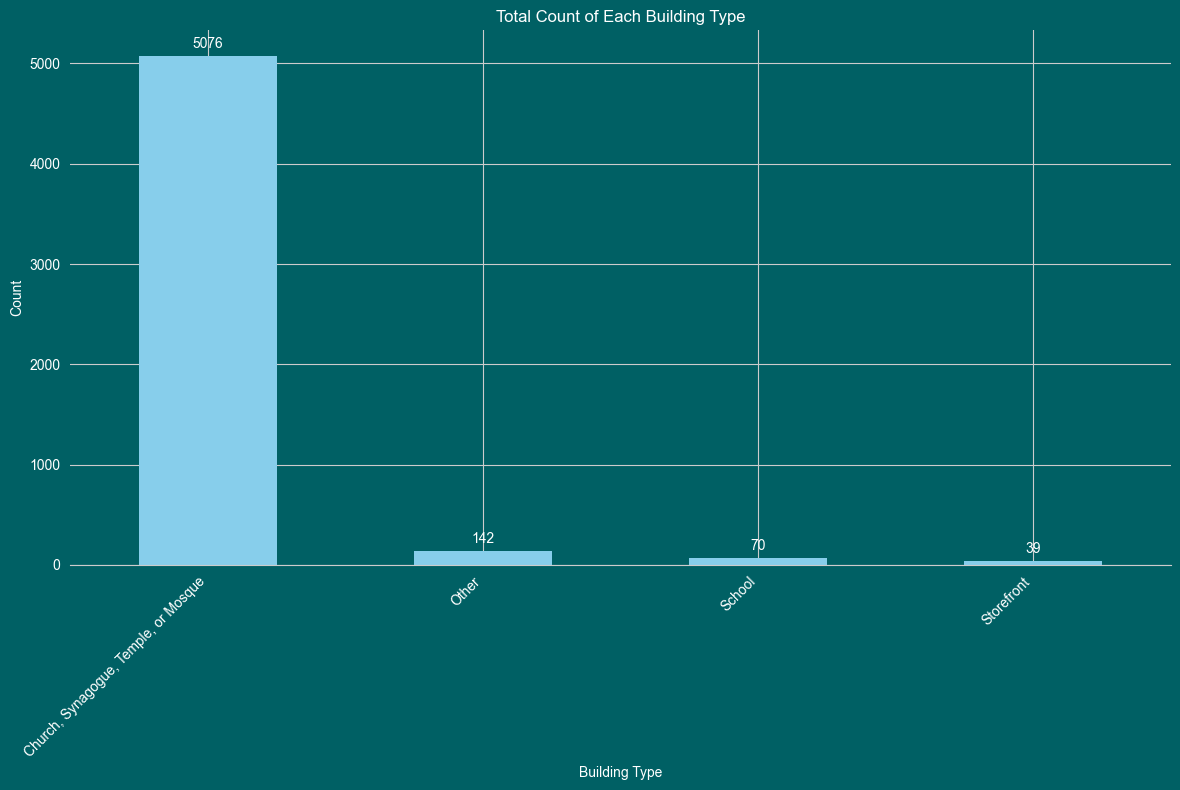

In [96]:
# Plotting
building_type_counts = df_facilities['Building Type'].value_counts()

plt.figure(figsize=(12, 8))
ax = building_type_counts.plot(kind='bar', color='skyblue')

# Adding data labels
for i, value in enumerate(building_type_counts):
    ax.text(i, value + 50, str(value), ha='center', va='bottom')

plt.title('Total Count of Each Building Type')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [67]:
# Inferential Analysis

# Select specific features and drop rows with missing target data
df_facilities_inferential = data[['Building Type', 'Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use', 'Permit & Purpose', 'change_category']]

# Drop rows with missing target data
df_facilities_inferential = df_facilities_inferential.dropna(subset=['change_category'])

# Convert facility type columns to categorical
facilities_types = ['Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use']
for col in facilities_types:
    df_facilities_inferential[col] = df_facilities_inferential[col].astype('category')

# Function to perform Chi-Square test
def perform_chi2_test(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_val

# Perform Chi-Square test for each feature
chi2_results = {feature: perform_chi2_test(df_facilities_inferential, feature) for feature in facilities_types}

# Display Chi-Square results
for feature, (chi2_stat, p_val) in chi2_results.items():
    print(f"Chi-Square test for {feature}: Chi2-statistic = {chi2_stat:.4f}, p-value = {p_val:.4e}")

Chi-Square test for Artwork/Architecture: Chi2-statistic = 0.0000, p-value = 1.0000e+00
Chi-Square test for Remodel: Chi2-statistic = 7.6158, p-value = 2.2195e-02
Chi-Square test for Home School: Chi2-statistic = 9.2488, p-value = 9.8093e-03
Chi-Square test for Primary & Secondary Education: Chi2-statistic = 18.4428, p-value = 9.8899e-05
Chi-Square test for Building Use: Chi2-statistic = 0.0000, p-value = 1.0000e+00


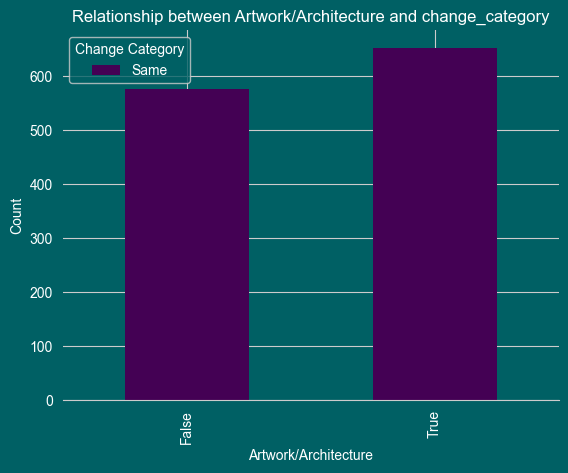

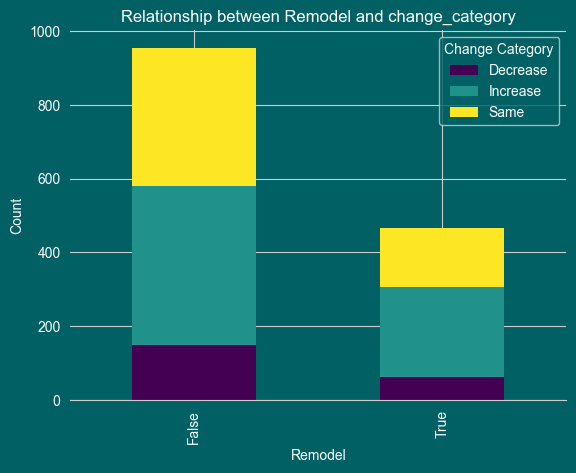

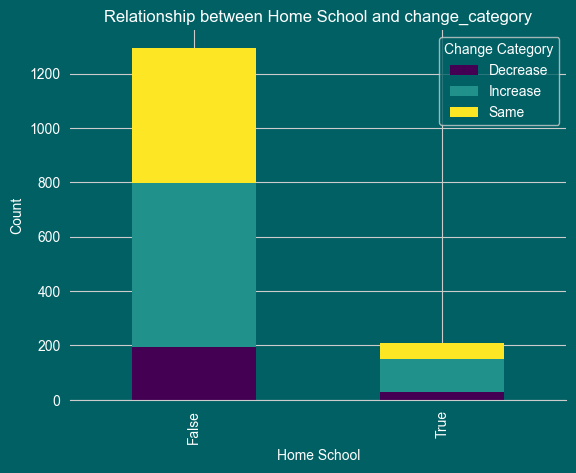

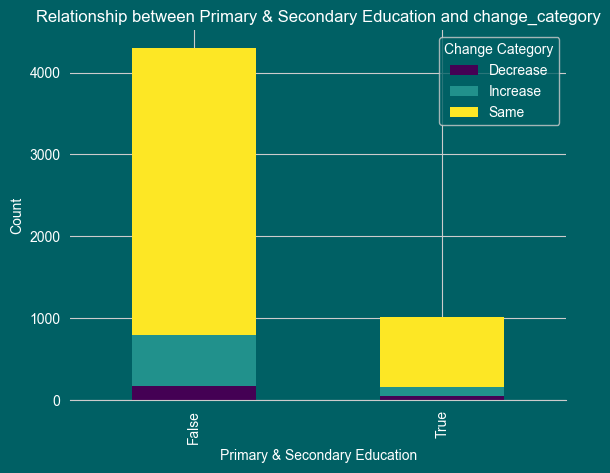

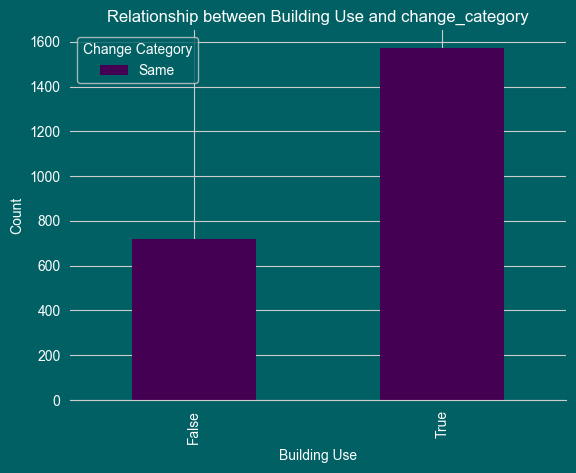

In [68]:
# Function to plot relationship
def plot_relationship(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Relationship between {feature} and change_category')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Change Category')
    plt.show()

# Plot relationships
for feature in facilities_types:
    plot_relationship(df_facilities_inferential, feature)

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [69]:
# Determine NaN value counts in each column
nan_counts = df_facilities.isnull().sum()
print("NaN value counts in each column:")
print(nan_counts)

NaN value counts in each column:
Building Type                       6
Artwork/Architecture             4105
Remodel                          3913
Home School                      3828
Primary & Secondary Education      15
Building Use                     3040
Permit & Purpose                 4920
change_category                     0
dtype: int64


## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

C:\Users\natha\AppData\Local\Temp\ipykernel_11400\1362703646.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_facilities_rf[col] = df_facilities_rf[col].fillna(False)


Accuracy of the Random Forest model: 0.8369


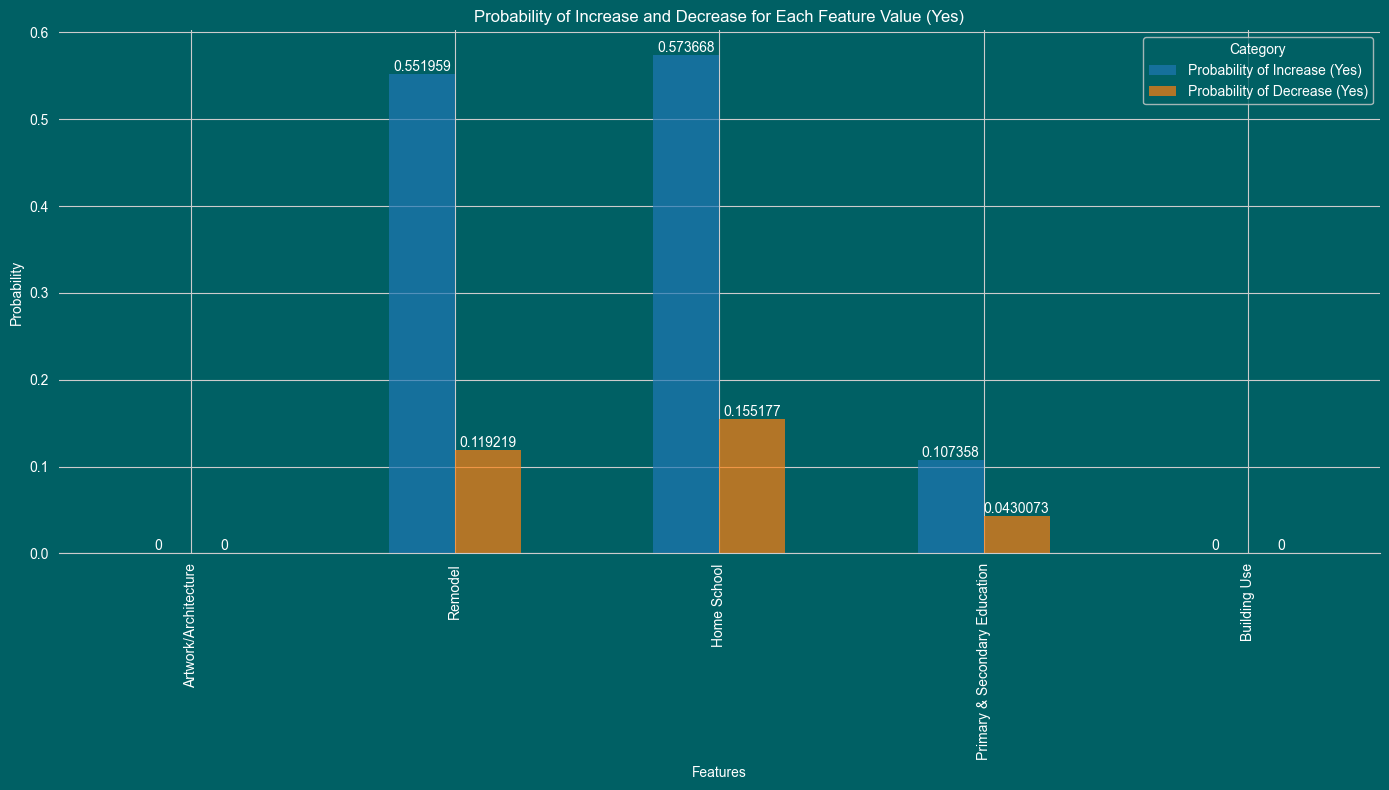

In [97]:
# Random Forest 1

# Select specific features
selected_columns = ['Artwork/Architecture', 'Remodel', 'Home School', 'Primary & Secondary Education', 'Building Use', 'change_category']
df_facilities_rf = data[selected_columns].copy()

# Replace NaN or missing values with False, except for the categorical column 'change_category'
for col in df_facilities_rf.columns:
    if col != 'change_category':  # Exclude the categorical column
        df_facilities_rf[col] = df_facilities_rf[col].fillna(False)

# Prepare features and target
X = df_facilities_rf.drop('change_category', axis=1)
y = df_facilities_rf['change_category']

# Convert Boolean features to int
X = X.astype(int)

# Drop rows with missing values (if any)
X = X.dropna()
y = y[X.index]  # Keep y aligned with X after dropping rows

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities
probs = rf_model.predict_proba(X_test)

# Convert probabilities to DataFrame
probs_df = pd.DataFrame(probs, columns=rf_model.classes_, index=X_test.index)

# Calculate mean probabilities for 'Increase' and 'Decrease'
feature_probs = {}

for feature in X.columns:
    feature_probs[feature] = {
        'Increase': probs_df.loc[X_test[feature] == 1, 'Increase'].mean(),
        'Decrease': probs_df.loc[X_test[feature] == 1, 'Decrease'].mean()
    }

# Convert to DataFrame for plotting
feature_probs_df = pd.DataFrame(feature_probs).T
feature_probs_df.columns = ['Probability of Increase (Yes)', 'Probability of Decrease (Yes)']

# Plotting
ax = feature_probs_df.plot(kind='bar', figsize=(14, 8), alpha=0.7)

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.title('Probability of Increase and Decrease for Each Feature Value (Yes)')
plt.xlabel('Features')
plt.ylabel('Probability')
plt.legend(title='Category')
plt.tight_layout()

# Show the plot
plt.show()

Accuracy of the Random Forest model: 0.8244


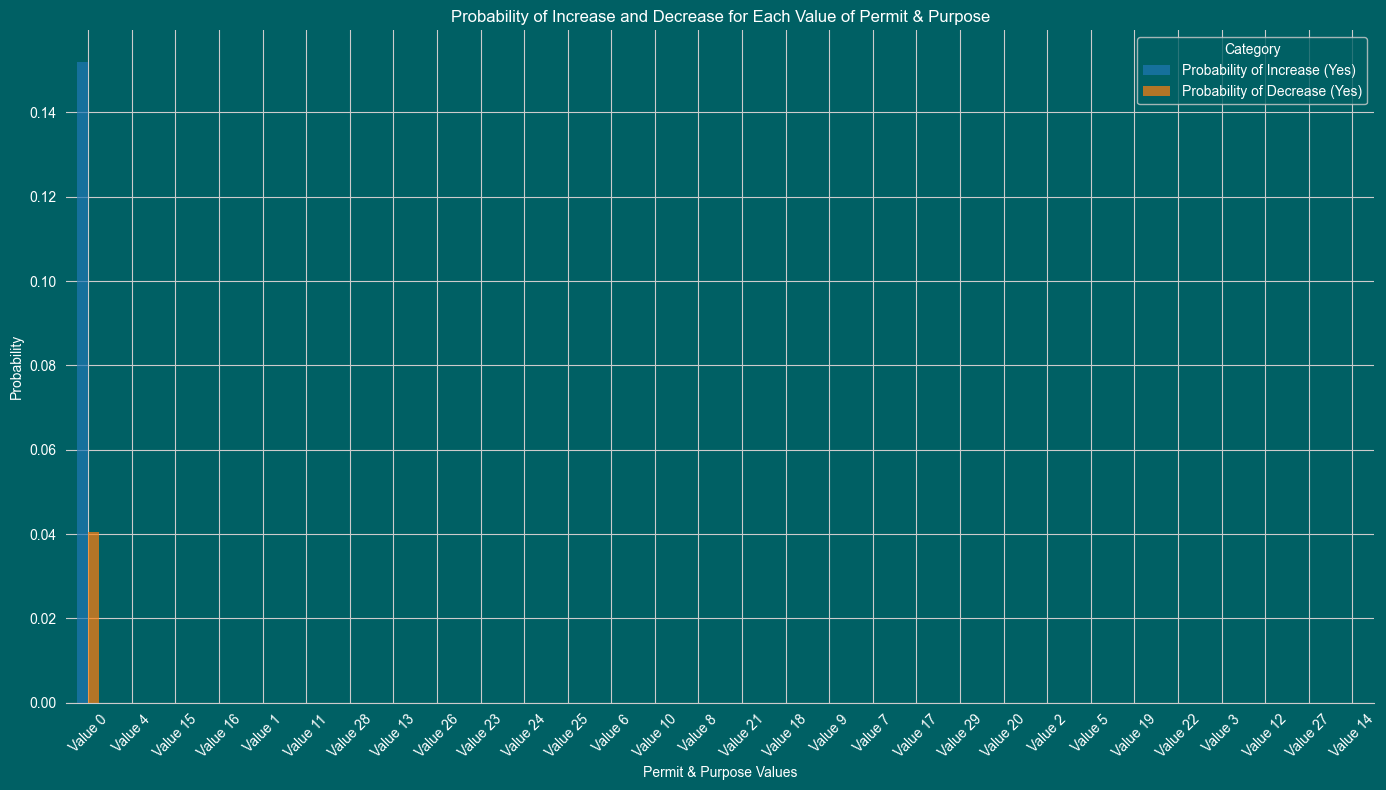

In [73]:
# Random Forest 2

# Select specific features
selected_columns = ['Permit & Purpose', 'change_category']
df_facilities_rf2 = data[selected_columns].copy()

# Replace NaN or missing values with False, except for the categorical column 'change_category'
for col in df_facilities_rf2.columns:
    if col != 'change_category':  # Exclude the target column
        df_facilities_rf2[col] = df_facilities_rf2[col].fillna(False)

# Convert PERMPURP to categorical and then to numeric codes
df_facilities_rf2['Permit & Purpose'] = df_facilities_rf2['Permit & Purpose'].astype('category').cat.codes

# Prepare features and target
X = df_facilities_rf2.drop('change_category', axis=1)
y = df_facilities_rf2['change_category']

# Convert Boolean features to int (if any)
X = X.astype(int)

# Drop rows with missing values (if any)
X = X.dropna()
y = y[X.index]  # Keep y aligned with X after dropping rows

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities
probs = rf_model.predict_proba(X_test)

# Convert probabilities to DataFrame
probs_df = pd.DataFrame(probs, columns=rf_model.classes_, index=X_test.index)

# Calculate mean probabilities for 'Increase' and 'Decrease'
feature_probs = {}

# Get unique values of PERMPURP
unique_values = df_facilities_rf2['Permit & Purpose'].unique()

for value in unique_values:
    feature_probs[value] = {
        'Increase': probs_df.loc[X_test['Permit & Purpose'] == value, 'Increase'].mean(),
        'Decrease': probs_df.loc[X_test['Permit & Purpose'] == value, 'Decrease'].mean()
    }

# Convert to DataFrame for plotting
feature_probs_df = pd.DataFrame(feature_probs).T
feature_probs_df.columns = ['Probability of Increase (Yes)', 'Probability of Decrease (Yes)']

# Plot
feature_probs_df.plot(kind='bar', figsize=(14, 8), alpha=0.7)
plt.title('Probability of Increase and Decrease for Each Value of Permit & Purpose')
plt.xlabel('Permit & Purpose Values')
plt.ylabel('Probability')
plt.xticks(ticks=range(len(unique_values)), labels=[f'Value {v}' for v in unique_values], rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.